In [12]:
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer as Trainer
import ray.rllib.agents.ppo.ppo as ppo
from ray.tune.logger import pretty_print
from ray.tune.registry import register_env

print(ray.__version__)
import itertools
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy

import qsd_library_multiple as qsdm
import sdp

# Common parameters for all runs
num_gpus = 0.25
num_workers = 4
ray_init_kwargs = {"object_store_memory": 5*1024**3, "num_cpus": num_workers+1}

0.7.3


In [4]:
# General function for testing
def single_test(defaultconfig, training_trials, evaluation_trials, check, lr = 0.00005, num_workers = 4, num_gpus = 0.25):
    ray.shutdown()
    ray.init(**ray_init_kwargs)
    config = ppo.DEFAULT_CONFIG.copy()
    if (num_gpus > 0):
        config["num_gpus"] = num_gpus
    config["num_workers"] = num_workers
    config["lr"] = lr
    config["num_sgd_iter"] = 15
    config["env_config"] = defaultconfig
    trainer = Trainer(config=config, env=qsdm.QSDEnv)
    for i in range(training_trials):
        result = trainer.train()
        print("train iteration",i+1,"/",training_trials," avg_reward =", 
              result["episode_reward_mean"]," timesteps =", result["timesteps_total"])
        if i % check == check-1:
            checkpoint = trainer.save()
            print("checkpoint saved at", checkpoint)
    avgR = 0
    for i in range(evaluation_trials):
        env=qsdm.QSDEnv(defaultconfig)
        obs = env.reset()
        done = False
        while not done:
            action = trainer.compute_action(obs)
            obs, r, done, _ = env.step(action)
            avgR += r
    return avgR/evaluation_trials


# Figure 1- Helstrom vs RLNN performance

In [ ]:
total_trials = 10
training_trials = 1000
evaluation_trials = 5000
check = 50
d = np.array([2,2,2])
m = 2
quantization = 20
separable = True
q = np.array([1/2, 1/2])
train_check = 10
lr = 0.00005
num_gpus = 0.25
num_workers = 10

bigvec = np.zeros((total_trials, int(training_trials/train_check)))
vec_SDP = []
newrho = np.zeros([total_trials,m,3,2,2])

for j in range(total_trials):
    print("Starting round",j,"of",total_trials)
    rho, _ = qsdm.generate_initial_state(d, m, False)
    newrho[j] = rho
    np.save('rhotxt_fig1', newrho)
    vec_SDP.append(sdp.SDP(rho, q, len(d)))
    print("SDP: "+str(vec_SDP[-1]))
    defaultconfig = {"rho": copy.copy(rho), "q": copy.copy(q),  
                 "quantization" : quantization, "d" : d, "separable": True}
    
    vec = []
    ray.shutdown()
    ray.init(**ray_init_kwargs)
    config = ppo.DEFAULT_CONFIG.copy()
    if (num_gpus > 0):
        config["num_gpus"] = num_gpus
    config["num_workers"] = num_workers
    config["lr"] = lr
    config["num_sgd_iter"] = 15
    config["env_config"] = defaultconfig
    trainer = Trainer(config=config, env=qsdm.QSDEnv)
    for _ in range(training_trials):
        result = trainer.train();
        print("train iteration",_+1,"/",training_trials," avg_reward =", 
              result["episode_reward_mean"]," timesteps =", result["timesteps_total"])
        if _ % check == 0:
            checkpoint = trainer.save()
            print("checkpoint saved at", checkpoint)
        rew = 0
        if _ % train_check == 0:
            rew = 0
            for i in range(evaluation_trials):
                env=qsdm.QSDEnv(defaultconfig)
                obs = env.reset()
                done = False
                while not done:
                    action = trainer.compute_action(obs)
                    obs, r, done, _ = env.step(action)
                    rew += r
            vec.append(rew/evaluation_trials)       
    bigvec[j] = vec
    np.save('bigvec_fig1', bigvec) 
    np.save('vec_SDP_fig1', vec_SDP)
 

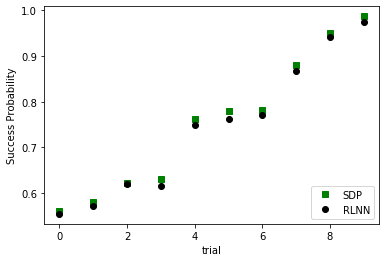

In [4]:
vec_SDP = np.array([vec_SDP]).flatten()
vec_NN = bigvec[:,-1]
vec_NN = np.array([vec_NN]).flatten()

arrinds = vec_SDP.argsort()
sorted_SDP = vec_SDP[arrinds]
sorted_NN = vec_NN[arrinds]

X = np.arange(total_trials)
plt.plot(X, sorted_SDP, marker = "s", color = 'green', linewidth = 0, label = 'SDP')
plt.plot(X, sorted_NN, color = 'black', marker = 'o', linewidth = 0, label = 'RLNN')
plt.xlabel('trial')
plt.ylabel('Success Probability')
plt.legend(loc="lower right")
plt.show()

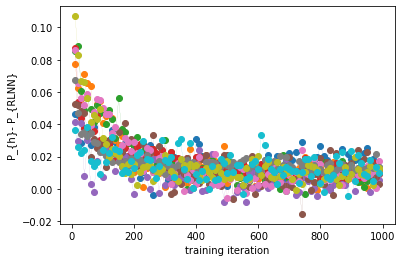

In [5]:
Xvec = train_check*np.arange(int(training_trials/train_check))
for _ in range(len(vec_SDP)):
    SDPvalue = vec_SDP[_]
    diff_vec = SDPvalue*np.ones(int(training_trials/train_check))- bigvec[_]
    plt.plot(Xvec[1:,], diff_vec[1:,], marker = 'o', linewidth = 0.1)
plt.xlabel('training iteration')
plt.ylabel('P_{h}- P_{RLNN}')
plt.show()

# RLNN vs Collective Optimal as a function of n for TPQS with special structure

In [ ]:
max_n = 6
training_trials = 1000
evaluation_trials = 7500
check = 50
quantization = 20
separable = True
vec_NN = []

def ind_rho_func(vec):
    rho0, rho1 = np.array([[0.85, 0],[0, 0.15]]), np.array([[0.15, 0], [0, 0.85]])
    rhoset = np.array([rho0, rho1])
    intvec = np.array(list(vec),dtype=int)
    return rhoset[intvec]  

def full_rho_func(n):
    binarr =  np.array(["".join(seq) for seq in itertools.product("01", repeat=n)])
    return np.array([ind_rho_func(binarr[_]) for _ in range(len(binarr)) ])

for j in range(1,max_n+1):
    print("Starting n = ",j,"out of",max_n)
    rho = full_rho_func(j)
    q = 1/(2**j)*np.ones(2**j) 
    d = np.full(j,2) 
    defaultconfig = {"rho": copy.copy(rho), "q": copy.copy(q),  
                 "quantization" : quantization, "d" : d, "separable": True}
    vec_NN.append(single_test(defaultconfig, training_trials, evaluation_trials, check, num_workers = num_workers))
    np.save('vec_NN_fig2', vec_NN)    

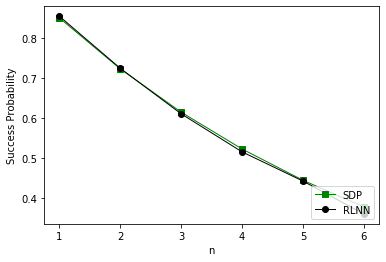

In [9]:
collective = 0.85 ** np.arange(1,max_n+1)
X = np.arange(1,max_n+1)
plt.plot(X, collective, marker = "s", color = 'green', linewidth = 1, label = 'SDP')
plt.plot(X, vec_NN, color = 'black', marker = 'o', linewidth = 1, label = 'RLNN')
plt.xlabel('n')
plt.ylabel('Success Probability')
plt.legend(loc="lower right")
plt.show()

# RLNN vs PGM

In [ ]:
def PGM(rho, q, d):
    S = np.zeros((2**(len(d)), 2**(len(d))))
    for k in range(len(q)):
         S = S + q[k]*qsdm.cum_kron(rho[k])
    E = []
    for k in range(len(q)):
        Sinv = np.linalg.pinv(scipy.linalg.sqrtm(S))
        M = q[k]*Sinv@qsdm.cum_kron(rho[k])@Sinv
        E.append(M)
    return E

def PGM_success_prob(rho, q, d):
    Pi = PGM(rho, q, d)
    psucc = 0
    for k in range(len(q)):
        psucc += q[k]*np.trace(Pi[k]@qsdm.cum_kron(rho[k]))
    return psucc

total_trials = 20
training_trials = 500
evaluation_trials = 5000
check = 150
d = np.array([2,2,2])
m = 5
quantization = 20
separable = True
q = np.full(5,1/5)

vec_NN = []
vec_PGM = []
newrho = np.zeros([total_trials,m,3,2,2])

for j in range(total_trials):
    print("Starting round",j)
    rho, _ = qsdm.generate_initial_state(d, m)
    newrho[j] = rho
    np.save('rhotxt_fig3', newrho)
    vec_PGM.append(PGM_success_prob(rho, q, d))
    defaultconfig = {"rho": copy.copy(rho), "q": copy.copy(q),  
                 "quantization" : quantization, "d" : d, "separable": True}
    vec_NN.append(single_test(defaultconfig, training_trials, evaluation_trials, check, num_workers = num_workers))
    np.save('vec_NN_fig3', vec_NN)
    np.save('vec_PGM_fig3', vec_PGM)

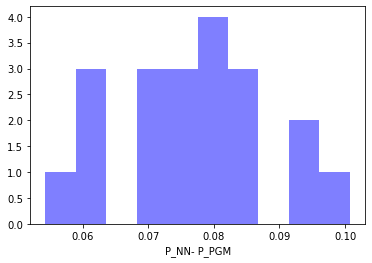

In [11]:
vec_PGM = np.array([vec_PGM]).flatten()
vec_NN = np.array([vec_NN]).flatten()

vec = vec_NN- vec_PGM
num_bins = 10
n, bins, patches = plt.hist(vec, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('P_NN- P_PGM')
plt.show()


# Trine 

In [ ]:
U = np.array([[np.cos(np.pi*2/(3)), -np.sin(np.pi*2/(3))],[np.sin(np.pi*2/(3)), np.cos(np.pi*2/(3))]])
Ut = np.array([[np.cos(np.pi*2/(3)), np.sin(np.pi*2/(3))],[-np.sin(np.pi*2/(3)), np.cos(np.pi*2/(3))]])


rho0 = np.array([[1,0],[0,0]])
rho1 = U@np.array([[1,0],[0,0]])@Ut
rho2 = U@U@np.array([[1,0],[0,0]])@Ut@Ut

training_trials = 1000
evaluation_trials = 5000
quantization = 24
check = 50
d = np.array([2,2])
m = 3
separable = True
q = np.array([1/3, 1/3, 1/3])
lr = 0.00005

defaultconfig = {"rho": np.array([[rho0, rho0],[rho1, rho1], [rho2, rho2]]), "q": np.array([1/3, 1/3, 1/3]),  
                 "quantization" : 24, "d" : np.array([2,2]), "separable": True}

vec = []

ray.shutdown()
ray.init(**ray_init_kwargs)
config = ppo.DEFAULT_CONFIG.copy()
if (num_gpus>0):
    config["num_gpus"] = num_gpus
config["num_workers"] = num_workers
config["lr"] = lr
config["env_config"] = defaultconfig
trainer = Trainer(config = config, env = qsdm.TrineEnv)
for i in range(training_trials):
    result = trainer.train()
    if i % check == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)
    if i % 10 == 0:
        avgR = 0
        for i in range(evaluation_trials):
            env=qsdm.TrineEnv(defaultconfig)   
            obs = env.reset()
            done = False
            while not done:
                action = trainer.compute_action(obs)
                obs, r, done, _ = env.step(action)
                avgR += r
        print(avgR/evaluation_trials)
        vec.append(avgR/evaluation_trials)

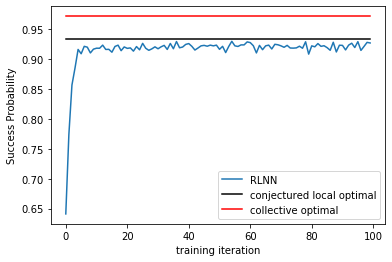

In [19]:
vec_local = np.full(int(np.ceil(training_trials/10)),0.933)
vec_collective = np.full(int(np.ceil(training_trials/10)),0.971)
plt.plot(vec, label = 'RLNN')
plt.plot(vec_local, color = 'black', linewidth = 1.5, label = 'conjectured local optimal')
plt.plot( vec_collective, color = 'red', label = 'collective optimal')
plt.legend(loc="lower right")
plt.xlabel('training iteration')
plt.ylabel('Success Probability')
plt.show()

# SDP vs RLNN for m=2, n=3

In [ ]:
vec_NN = []
vec_NN_err = []
vec_SDP = []

total_trials = 5 # 3
training_trials = 1000 # 100
evaluation_trials = 5000 # 500
check = 250
d = np.array([2,2,2])
m = 2
quantization = 20
separable = True
q = np.array([1/2, 1/2])
lr = 0.00005

newrho = np.zeros([total_trials,m,3,2,2])
for j in range(total_trials):
    rho, _ = qsdm.generate_initial_state(d, m)
    newrho[j] = rho
    np.save('rhotxt_fig5', newrho)
    vec_SDP.append(sdp.SDP(rho, q, len(d)))
    trialvec = []
    for _ in range(5):
        defaultconfig = {"rho": copy.copy(rho), "q": copy.copy(q),  
                 "quantization" : quantization, "d" : d, "separable": True}
        trialvec.append(single_test(defaultconfig, training_trials, evaluation_trials, check))
    vec_NN.append(np.mean(np.array([trialvec])))
    vec_NN_err.append(np.var(np.array([trialvec])))
    np.save('vec_NN_fig5', vec_NN)
    np.save('vec_NN_err_fig5', vec_NN_err)
    np.save('vec_SDP_fig5', vec_SDP)

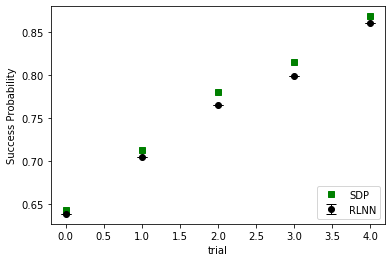

In [23]:
vec_SDP = np.array([vec_SDP]).flatten()
vec_NN = np.array([vec_NN]).flatten()
vec_NN_err = np.array([vec_NN_err]).flatten()

arrinds = vec_SDP.argsort()
sorted_SDP = vec_SDP[arrinds]
sorted_NN = vec_NN[arrinds]
sorted_NN_err = vec_NN_err[arrinds]

X = np.arange(total_trials)
plt.xlabel('trial')
plt.ylabel('Success Probability')
plt.errorbar(X, sorted_SDP, marker = "s", color = 'green', linewidth = 0, label = 'SDP')
plt.errorbar(X, sorted_NN, sorted_NN_err, elinewidth=1, capsize= 5.0,  color='black', marker = "o", linewidth=0, label = 'RLNN')
plt.legend(loc="lower right")

# SDP vs RLNN for m=3, n=3

In [ ]:
vec_NN = []
vec_NN_err = []
vec_SDP = []

total_trials = 5
training_trials = 1000
evaluation_trials = 5000
check = 500
d = np.array([2,2,2])
m = 3
quantization = 20
separable = True
q = np.array([1/3, 1/3, 1/3])
lr = 0.00005

newrho = np.array([np.array([np.zeros((3, 2, 2)) for _ in range(m)]) for _ in range(total_trials)])
for j in range(total_trials):
    rho, _ = qsdm.generate_initial_state(d, m)
    newrho[j] = rho
    np.save('rhotxt_fig6', newrho)
    vec_SDP.append(sdp.SDP(rho, q, len(d)))
    trialvec = []
    for _ in range(5):
        defaultconfig = {"rho": copy.copy(rho), "q": copy.copy(q),  
                 "quantization" : quantization, "d" : d, "separable": True}
        trialvec.append(single_test(defaultconfig, training_trials, evaluation_trials, check))
    vec_NN.append(np.mean(np.array([trialvec])))
    vec_NN_err.append(np.var(np.array([trialvec])))
    np.save('vec_NN_fig6', vec_NN)
    np.save('vec_NN_err_fig6', vec_NN_err)
    np.save('vec_SDP_fig6', vec_SDP)

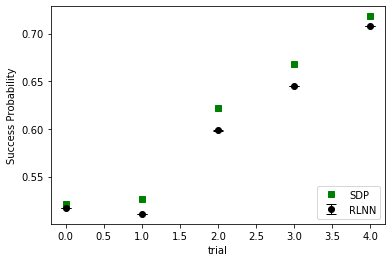

In [8]:
vec_SDP = np.array([vec_SDP]).flatten()
vec_NN = np.array([vec_NN]).flatten()
vec_NN_err = np.array([vec_NN_err]).flatten()

arrinds = vec_SDP.argsort()
sorted_SDP = vec_SDP[arrinds]
sorted_NN = vec_NN[arrinds]
sorted_NN_err = vec_NN_err[arrinds]

X = np.array([_ for _ in range(total_trials)])
plt.xlabel('trial')
plt.ylabel('Success Probability')
plt.errorbar(X, sorted_SDP, marker = "s", color = 'green', linewidth = 0, label = 'SDP')
plt.errorbar(X, sorted_NN, sorted_NN_err, elinewidth=1, capsize= 5.0,  color='black', marker = "o", linewidth=0, label = 'RLNN')
plt.legend(loc="lower right")